# Data Preprocessing

## Importing Data
---
Complete the following:
- Use the parameter 'usecols' to select all columns from the raw data that are needed
- Use the parameter 'parse_dates' to have Pandas automatically parse date info as it is brought in
- Use the paremeter 'index_col' to set the index to the datetime column if this is time series data
- Use the .query() function to import data that's conditional upon another columns values

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import preprocessing
import seaborn as sns # Used for correlation heat map
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from skorch import NeuralNetClassifier, NeuralNetRegressor
from torch import nn
import torch.nn.functional as F
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator



    




raw_data = pd.read_csv('./data/TrainingSet.csv')

if isinstance(raw_data, pd.DataFrame):
    print("Data successfully imported.")
else:
    print("Data failed to import.")

    
# Remove unneeded columns
del raw_data['timestamp']    

# test_raw_data = pd.read_csv('./data/TestSet.csv')
# if isinstance(test_raw_data, pd.DataFrame):
#     print("Test data successfully imported.")
# else:
#     print("Test data failed to import.")

# Time series example
# hourly_weather_data = pd.read_csv('./data/raw_weather_data.csv', usecols=['DATE','REPORT_TYPE','HourlyDryBulbTemperature', 'HourlyPrecipitation'] , parse_dates=["DATE"], index_col="DATE").query("REPORT_TYPE == 'FM-15'")

print("Data Shape:",raw_data.shape) 
# print("Test Shape:",test_raw_data.shape) 

Data successfully imported.
Data Shape: (20000, 379)


## Formatting Data
---
Perform the following steps:
- Change file format
- Flatten data file
- Convert data that has been read in as 'object' type by Pandas to categorical or datetime data types where needed
- Anonymize or remove sensitive data
- Remove unneeded columns such as timestamps, counts, etc. that are guaranteed to have no relationship on the target
- Consider removing features with missing values if appropriate

In [3]:
formatted_data = raw_data.copy(deep=True)

# Convert dataframe object data to categorical data
formatted_data[formatted_data.select_dtypes(['object']).columns] = formatted_data.select_dtypes(['object']).apply(lambda x: x.astype('category'))

# Anonymize sensitive columns
# Code here

print("Data Shape:",formatted_data.shape)
print(formatted_data.dtypes.head(10))

Data Shape: (20000, 379)
cntryid               category
cntryid_e             category
age_r                  float64
gender_r              category
computerexperience    category
nativespeaker         category
edlevel3              category
monthlyincpr          category
yearlyincpr           category
lng_home              category
dtype: object


## Separate Data into Training, Validation, Test, and Target Sets
---
##### It is very important that this step is done prior to data imputation, normalization, one hot encoding or other preprocessing steps.

You should NEVER do anything which leaks information about your testing data BEFORE a split.  If you normalize before the split, then you will use the testing data to calculate the range or distribution of this data which leaks this information also into the training data and vice versa which "contaminates" your data and will lead to over-optimistic performance estimations on your testing data. This is true for all data preprocessing steps which change data based on all data points including also feature selection.

What you SHOULD do instead is to create the normalization only on the training data and use the preprocessing model coming out of the normalization operator.  This preprocessing model can then be applied like any other model on the testing data as well and will change the testing data based on the training data (which is ok) but not the other way around.

In [4]:
# Separate data into training, validation, and test sets
train_set, test_set, train_targets, test_targets = train_test_split(formatted_data, formatted_data['job_performance'], test_size=0.2)


# Set target and drop from training/test set data
del train_set['job_performance']
del test_set['job_performance']

print("Training Set Shape:",train_set.shape)
print("Test Set Shape:",test_set.shape)
print(train_targets.head(5))
print(test_targets.head(5))

Training Set Shape: (16000, 378)
Test Set Shape: (4000, 378)
7063     2839.728205
4309     2422.636497
8102     2276.712858
16617    2498.442852
18398    2487.473308
Name: job_performance, dtype: float64
6173     2540.483752
13687    2751.641890
16952    3156.473677
8445     2727.079721
14974    3783.485098
Name: job_performance, dtype: float64


In [278]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

cleaned_train_set = train_set.copy(deep=True)
cleaned_test_set = test_set.copy(deep=True)

num_colums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']  

test_numerical_features = list(cleaned_test_set.select_dtypes(include=num_colums).columns)  

# numeric_features = ['Salary']
numeric_features = list(cleaned_train_set.select_dtypes(include=num_colums).columns)  
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler())])

categorical_features = cleaned_train_set.select_dtypes(['category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline1 = Pipeline(steps=[('preprocessor', preprocessor)]) 

print("CLF",pipeline1.fit_transform(cleaned_train_set))

TypeError: '<' not supported between instances of 'str' and 'bool'

## Cleaning Data
---
Perform the following steps on the training, validation, and test data separately:
- If features with missing values cannot be removed, conduct data imputation appropriately
- Normalize or standardize the numerical data depending on the model's needs
- One hot encode or rank the categorical data depending on the model's needs

### Data Imputation

### Normalizing (Min-Max Scaling) vs Standardizing Data
Which one should be done depends on the application.

The goal of normalization is to change the values of numeric columns in the dataset to a common scale of 0-1, without distorting differences in the ranges of values. Normalization is used with image processing, where pixel intensities have to be normalized to fit within a certain range (i.e., 0 to 255 for the RGB color range). Also, typical neural network algorithms require data that is on a 0-1 scale.

Standardization is the process of rescaling and shifting the data so that it is centered over zero. The resulting data will have a mean = 0 and a standard deviation = 0. Standardization may be especially crucial in clustering analyses in order to compare similarities between features based on certain distance measures. Another prominent example is the Principal Component Analysis, where we usually prefer standardization over normalization, since we are interested in the components that maximize the variance (depending on the question and if the PCA computes the components via the correlation matrix instead of the covariance matrix).


### One Hot Encoding

One hot encoding normalizes categorical data so that each item is converted to a systems of 1s and 0s.

In [5]:
from sklearn.impute import SimpleImputer

cleaned_train_set = train_set.copy(deep=True)
cleaned_test_set = test_set.copy(deep=True)

# Remove features where data is missing if appropriate
# Code here

# ==================================== Remove Columns w Duplicate Data ================================================
# print("Data Duplication:")
# current_columns = cleaned_train_set.shape[1]
# cleaned_train_set.T.drop_duplicates().T
# print("  ",current_columns - cleaned_train_set.shape[1], "features with duplicated data removed in training set.")

# test_current_columns = cleaned_test_set.shape[1]
# cleaned_test_set.T.drop_duplicates().T
# print("  ",test_current_columns - cleaned_test_set.shape[1], "features with duplicated data removed in test set.")

# ==================================== Data Imputation ================================================
# Fill all blank cells of numerical columns with zeros for training, validation, and test data separately
# To prevent mean, median, or other data from being leaked into the test set
print("Data Imputation:")
num_colums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']  
train_numerical_columns = list(cleaned_train_set.select_dtypes(include=num_colums).columns)  
test_numerical_columns = list(cleaned_test_set.select_dtypes(include=num_colums).columns)  

previous_columns = list(cleaned_test_set.columns) 
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imputed_data = imputer.fit_transform(cleaned_train_set.values)
cleaned_train_set[previous_columns] = imputed_data
# cleaned_train_set = pd.DataFrame(imputed_data, columns = cleaned_train_set.columns)
# Convert data types back to correct ones
# cleaned_train_set[train_numerical_columns] = cleaned_train_set[train_numerical_columns].apply(lambda x: x.astype('float64'))
cleaned_train_set[cleaned_train_set.select_dtypes(['object']).columns] = cleaned_train_set.select_dtypes(['object']).apply(lambda x: x.astype('category'))
cleaned_train_set = cleaned_train_set.reset_index(drop=True)

print("  Any remaining null values in training data?", cleaned_train_set.isnull().values.any())

imputed_data = imputer.transform(cleaned_test_set)
cleaned_test_set = pd.DataFrame(imputed_data, columns = cleaned_test_set.columns)
# Convert data types back to correct ones
cleaned_test_set[test_numerical_columns] = cleaned_test_set[test_numerical_columns].apply(lambda x: x.astype('float64'))
cleaned_test_set[cleaned_test_set.select_dtypes(['object']).columns] = cleaned_test_set.select_dtypes(['object']).apply(lambda x: x.astype('category'))

print("  Any remaining null values in training data?", cleaned_test_set.isnull().values.any())

# Drops all categorical columns for now
# cleaned_training_set = cleaned_training_set[numerical_columns].fillna(0)


# ==================================== Normalization ================================================
# A) Normalize all numerical data
print("Data Normalization:")
minmax_scale = preprocessing.MinMaxScaler().fit(cleaned_train_set[train_numerical_columns])
cleaned_train_set[train_numerical_columns] = minmax_scale.transform(cleaned_train_set[train_numerical_columns])

# minmax_scale = preprocessing.MinMaxScaler().fit(cleaned_test_set[test_numerical_columns])
cleaned_test_set[test_numerical_columns] = minmax_scale.transform(cleaned_test_set[test_numerical_columns])

# ==================================== Standardization ================================================
# B) Standardize all numerical data
# std_scale = preprocessing.StandardScaler().fit(cleaned_data[numerical_columns])
# cleaned_data[numerical_columns] = std_scale.transform(cleaned_data[numerical_columns])
print(cleaned_train_set.dtypes)
cleaned_train_set

Data Imputation:
  Any remaining null values in training data? False
  Any remaining null values in training data? False
Data Normalization:


C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


cntryid               category
cntryid_e             category
age_r                  float64
gender_r              category
computerexperience    category
nativespeaker         category
edlevel3              category
monthlyincpr          category
yearlyincpr           category
lng_home              category
cnt_h                 category
cnt_brth              category
reg_tl2               category
lng_bq                category
lng_ci                category
yrsqual                float64
yrsqual_t              float64
yrsget                 float64
vet                   category
ctryqual              category
birthrgn              category
nativelang            category
ctryrgn               category
imyrs                  float64
imyrs_c               category
imyrcat               category
ageg5lfs              category
ageg10lfs             category
ageg10lfs_t           category
edcat8                category
                        ...   
v240                  category
v186    

,cntryid,cntryid_e,age_r,gender_r,computerexperience,nativespeaker,edlevel3,monthlyincpr,yearlyincpr,lng_home,...,v69,v85,v50,v89,v127,v239,v224,v71,v105,row
0,Italy,Italy,0.723077,Male,Yes,Yes,High,Less than 10,Less than 10,999,...,Disagree,Agree,Agree,0,0,0.516452,0.999700,9609,0.999700,0.956730
1,United Kingdom,England (UK),0.707692,Female,Yes,Yes,High,10 to less than 25,10 to less than 25,eng,...,Strongly agree,Strongly agree,Disagree,0,0,0.033103,0.999700,9103,0.999700,0.794368
2,Greece,Greece,0.784615,Female,No,Yes,Low,25 to less than 50,0,ell,...,Agree,Agree,Agree,0,0,0.522152,0.999700,4761,0.999700,0.834193
3,United States,United States,0.000000,Male,Yes,No,High,0,0,999,...,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,0,0,0.999700,1.000000,9996,1.000000,0.960063
4,Turkey,Turkey,0.276923,Male,Yes,Yes,Medium,0,0,999,...,0,0,0,0,0,0.999700,0.311331,9996,0.000000,0.205576
5,Poland,Poland,0.507692,Male,Yes,Yes,High,25 to less than 50,25 to less than 50,pol,...,Disagree,Agree,Agree,0,0,0.312231,0.999700,2220,0.999700,0.357523
6,France,France,0.661538,Female,Yes,Yes,High,25 to less than 50,25 to less than 50,fra,...,Strongly disagree,Disagree,Agree,0,0,0.341134,0.999700,6920,0.999700,0.326155
7,United Kingdom,England (UK),1.000000,Male,Yes,Yes,Low,50 to less than 75,50 to less than 75,eng,...,Agree,Agree,Agree,0,0,0.132113,0.999700,4322,0.999700,0.644516
8,Norway,Norway,0.830769,Male,Yes,No,High,75 to less than 90,75 to less than 90,nor,...,Disagree,Agree,Neither agree nor disagree,0,0,1.000000,0.999700,84,0.999700,0.206153
9,United States,United States,0.000000,Male,Yes,Yes,High,0,0,999,...,Disagree,Disagree,Disagree,0,0,1.000000,0.999700,9999,0.999700,0.167152


In [6]:
# ==================================== One Hot Encoding ================================================
# Reduce multicollinearity by dropping the first columne created with one hot encoding (drop_first = True)
train_categorical_columns = cleaned_train_set.select_dtypes(['category']).columns
cleaned_train_set = pd.get_dummies(cleaned_train_set, columns=train_categorical_columns, drop_first = True).fillna(0)

test_categorical_columns = cleaned_test_set.select_dtypes(['category']).columns
cleaned_test_set = pd.get_dummies(cleaned_test_set, columns=test_categorical_columns, drop_first = True).fillna(0)

print(cleaned_train_set.head(10))
# cleaned_test_set
# test_categorical_columns = cleaned_test_set.select_dtypes(['category']).columns
# cleaned_test_set = pd.get_dummies(cleaned_test_set, columns=test_categorical_columns, drop_first = True).fillna(0)

# print(cleaned_train_set.dtypes.head(10))
# print("Columns", train_categorical_columns)
print("Train shape:",cleaned_train_set.shape)
print("Test shape:",cleaned_test_set.shape)

print(cleaned_test_set.head(10))
cleaned_train_set

### One Hot Encoding using an encoder
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# categorical_data = cleaned_train_set.select_dtypes(include=['category'])
# categorical_columns = list(categorical_data.columns)
# ohe = preprocessing.OneHotEncoder()

# # for i in range(len(categorical_columns)):
# #     categorical_data[categorical_columns[i]] = ohe.fit_transform(categorical_data[categorical_columns[i]].astype(str)) 
# # categorical_data

# cleaned_test_set = pd.DataFrame(imputed_data, columns = cleaned_test_set.columns)

# test_data = ohe.fit_transform(categorical_data.astype(str)).toarray()
# test = pd.DataFrame(test_data)
# print(test)
# # enc = OneHotEncoder(handle_unknown = 'ignore', categorical_features=categorical_columns)
# # for col in cat_columns:
# # #         data[col] = le.fit_transform(data[col])
# #     cleaned_train_set = enc.fit_transform(cleaned_train_set)
# # categorical_data = enc.fit_transform(categorical_data)

# # cleaned_training_set
# #array([[1., 0., 0.],
# #       [0., 1., 0.],
# #       [1., 0., 0.],
# #       [0., 0., 1.]])

# # enc.transform(test).toarray()
# #array([[0., 1., 0.],
# #       [1., 0., 0.],
# #       [0., 0., 0.]])

      age_r   yrsqual  yrsqual_t    yrsget     imyrs   leavedu  nfehrsnjr  \
0  0.723077  0.818182   0.818182  0.000000  0.000000  0.423729   0.000000   
1  0.707692  0.727273   0.727273  0.500000  0.000000  0.372881   0.000000   
2  0.784615  0.272727   0.272727  0.000000  0.000000  0.203390   0.000000   
3  0.000000  0.636364   0.636364  0.000000  0.000000  0.000000   0.000000   
4  0.276923  0.500000   0.500000  0.000000  0.000000  0.000000   0.000000   
5  0.507692  0.681818   0.681818  0.772727  0.000000  0.406780   0.014583   
6  0.661538  0.636364   0.636364  0.681818  0.000000  0.389831   0.000000   
7  1.000000  0.000000   0.000000  0.000000  0.000000  0.000000   0.000000   
8  0.830769  0.954545   0.954545  0.954545  0.258065  0.508475   0.000000   
9  0.000000  0.727273   0.727273  0.727273  0.000000  0.000000   0.000000   

   nfehrsjr    nfehrs  isco1c  ...    v71_9602  v71_9603  v71_9609  v71_9700  \
0  0.000000  0.000000  0.0005  ...           0         0         0      

,age_r,yrsqual,yrsqual_t,yrsget,imyrs,leavedu,nfehrsnjr,nfehrsjr,nfehrs,isco1c,...,v71_9602,v71_9603,v71_9609,v71_9700,v71_9996,v71_9997,v71_9998,v71_9999,v71_C,v71_G
0,0.723077,0.818182,0.818182,0.000000,0.000000,0.423729,0.000000,0.000000,0.000000,0.0005,...,0,0,0,0,0,0,0,0,0,0
1,0.707692,0.727273,0.727273,0.500000,0.000000,0.372881,0.000000,0.003125,0.003125,0.0003,...,0,0,0,0,0,0,0,0,0,0
2,0.784615,0.272727,0.272727,0.000000,0.000000,0.203390,0.000000,0.000000,0.000000,0.0005,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.636364,0.636364,0.000000,0.000000,0.000000,0.000000,0.006250,0.006250,0.9997,...,0,0,0,0,1,0,0,0,0,0
4,0.276923,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.9997,...,0,0,0,0,1,0,0,0,0,0
5,0.507692,0.681818,0.681818,0.772727,0.000000,0.406780,0.014583,0.014583,0.029167,0.0003,...,0,0,0,0,0,0,0,0,0,0
6,0.661538,0.636364,0.636364,0.681818,0.000000,0.389831,0.000000,0.000000,0.004167,0.0003,...,0,0,0,0,0,0,0,0,0,0
7,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0001,...,0,0,0,0,0,0,0,0,0,0
8,0.830769,0.954545,0.954545,0.954545,0.258065,0.508475,0.000000,0.000000,0.062500,1.0000,...,0,0,0,0,0,0,0,0,0,0
9,0.000000,0.727273,0.727273,0.727273,0.000000,0.000000,0.000000,0.104167,0.104167,0.0003,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection
---
All of the features we find in the dataset may not be useful in building a machine learning model to make the necessary prediction. Using some of the features might even make the predictions worse. So, feature selection plays a huge role in building a machine learning model.


### Remove Constants & Low Variance Numerical Features


In [200]:
processed_train_set = cleaned_train_set.copy(deep=True)
processed_test_set = cleaned_test_set.copy(deep=True)
variance_threshold = 0.01

print("Shape",processed_test_set.shape)

# To remove constants only set threshold to 0
numerical_train_data = processed_train_set[train_numerical_columns] 
low_variance_filter = VarianceThreshold(threshold=variance_threshold)
previous_columns = processed_train_set.shape[1]
try: 
    low_variance_filter.fit(numerical_train_data)
except ValueError:    
    print("No features left!")

remaining_columns = list(numerical_train_data.columns[low_variance_filter.get_support()])
columns_to_remove = list(set(train_numerical_columns) - set(remaining_columns))


# Remove same columns from both train and test data
print("Train Set:")
print("  Starting numerical columns of",len(train_numerical_columns))
print("  Removing",len(columns_to_remove),"numerical features with a variance of less than",str(variance_threshold*100)+'%')
processed_train_set = processed_train_set.drop(columns=columns_to_remove)
print(" ",processed_train_set.shape[1],"features remaining")
processed_train_set.head()

print("Test Set:")
print("  Removing",len(columns_to_remove),"numerical features with a variance of less than",str(variance_threshold*100)+'%')
print(" ",processed_test_set.shape[1],"features remaining")
processed_test_set = processed_test_set.drop(columns=columns_to_remove)
print(" ",processed_test_set.shape[1],"features remaining")
processed_test_set.head()


Shape (4000, 2481)
Train Set:
  Starting numerical columns of 84
  Removing 34 numerical features with a variance of less than 1.0%
  2924 features remaining
Test Set:
  Removing 34 numerical features with a variance of less than 1.0%
  2481 features remaining
  2447 features remaining


,age_r,yrsqual,yrsqual_t,yrsget,leavedu,nfehrs,isco1c,isco2c,isco1l,isco2l,...,v71_9311,v71_9420,v71_9499,v71_9602,v71_9603,v71_9609,v71_9996,v71_9997,v71_9999,v71_G
0,0.000000,0.000000,0.000000,0.590909,0.000000,0.052083,0.0007,0.007001,0.9997,0.9997,...,0,0,0,0,0,0,0,0,0,0
1,0.538462,0.727273,0.727273,0.681818,0.425926,0.020833,0.0003,0.003201,0.9997,0.9997,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.545455,0.545455,0.545455,0.000000,0.000000,0.0007,0.007101,0.9997,0.9997,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.727273,0.727273,0.000000,0.000000,0.000000,0.0007,0.007101,0.9997,0.9997,...,0,0,0,0,0,0,0,0,1,0
4,0.923077,0.681818,0.681818,0.772727,0.425926,1.000000,0.0001,0.001200,0.9997,0.9997,...,0,0,0,0,0,0,0,0,0,0


### Remove Collinear Features

Multicollinearity refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related. We have perfect multicollinearity if, for example as in the equation above, the correlation between two independent variables is equal to 1 or −1. In practice, we rarely face perfect multicollinearity in a data set. More commonly, the issue of multicollinearity arises when there is an approximate linear relationship among two or more independent variables.

In the presence of multicollinearity, the estimate of one variable's impact on the dependent variable Y while controlling for the others tends to be less precise than if predictors were uncorrelated with one another. The usual interpretation of a regression coefficient is that it provides an estimate of the effect of a one unit change in an independent variable, X1, holding the other variables constant. If X1 is highly correlated with another independent variable, X2, in the given data set, then we have a set of observations for which X1 and X2 have a particular linear stochastic relationship. We don't have a set of observations for which all changes in X1 are independent of changes in X2, so we have an imprecise estimate of the effect of independent changes in X1.

In some sense, the collinear variables contain the same information about the dependent variable. If nominally "different" measures actually quantify the same phenomenon then they are redundant. Alternatively, if the variables are accorded different names and perhaps employ different numeric measurement scales but are highly correlated with each other, then they suffer from redundancy.

One of the features of multicollinearity is that the standard errors of the affected coefficients tend to be large. In that case, the test of the hypothesis that the coefficient is equal to zero may lead to a failure to reject a false null hypothesis of no effect of the explanator, a type II error.

Another issue with multicollinearity is that small changes to the input data can lead to large changes in the model, even resulting in changes of sign of parameter estimates.

A principal danger of such data redundancy is that of overfitting in regression analysis models. The best regression models are those in which the predictor variables each correlate highly with the dependent (outcome) variable but correlate at most only minimally with each other. Such a model is often called "low noise" and will be statistically robust (that is, it will predict reliably across numerous samples of variable sets drawn from the same statistical population).

So long as the underlying specification is correct, multicollinearity does not actually bias results; it just produces large standard errors in the related independent variables. More importantly, the usual use of regression is to take coefficients from the model and then apply them to other data. Since multicollinearity causes imprecise estimates of coefficient values, the resulting out-of-sample predictions will also be imprecise. And if the pattern of multicollinearity in the new data differs from that in the data that was fitted, such extrapolation may introduce large errors in the predictions.

#### Calculate & Display Collinear Heatmap

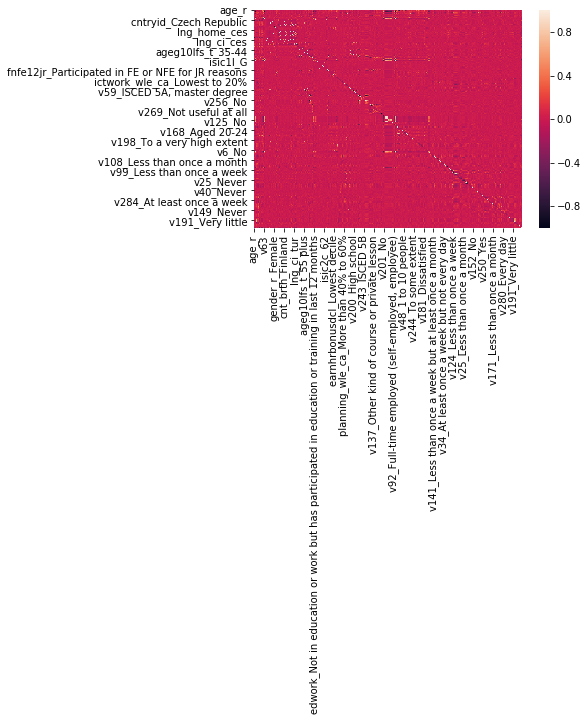

In [112]:
# Create correlation matrix and display heatmap
corr = processed_train_set.corr()
sns.heatmap(corr)

#### Remove Redundant Colinear Independent Variables

Starting features: 1131
Remaining non-collinear features in training set: 908
Remaining non-collinear features in testing set: 908


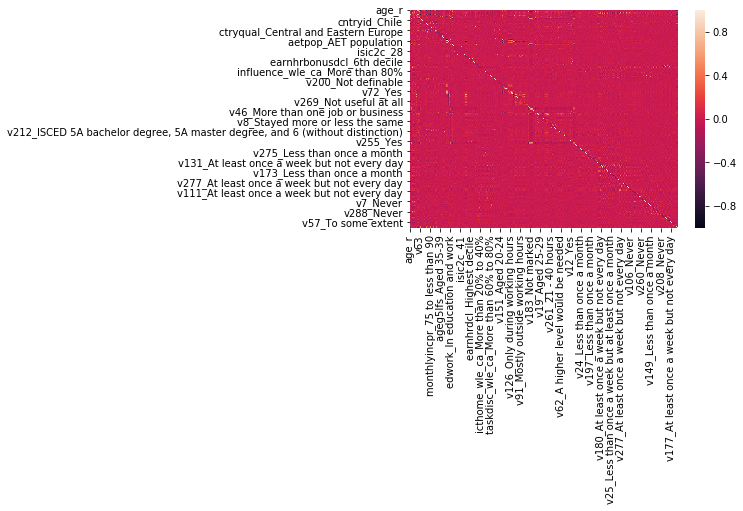

In [113]:
starting_columns = processed_train_set.shape[1]

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = processed_train_set.columns[columns]

#Remove same columns from both train and test set
processed_train_set = processed_train_set[selected_columns]
processed_test_set = processed_test_set[selected_columns]

print("Starting features:",starting_columns)
print("Remaining non-collinear features in training set:",processed_train_set.shape[1])
print("Remaining non-collinear features in testing set:",processed_test_set.shape[1])
corr2 = processed_train_set.corr()
sns.heatmap(corr2)

### Remove Statistically Insignificant Features

The p-value in a regression study is used to determine the statistical significance of a feature. Removal of different features from the dataset will have differing effects on the p-values of how other features effect the dataset. We can remove features systematically and measure the restulting p-values of the remaining features in each case. These measured p-values can be used to decide whether to keep a feature or not.

This is what we are doing in the code block below:
- First we calculate the p-values for all current columns.
- Then we locate the column with the highest p-value that's greater than set significance level (SL) and drop that column.
- Then we recalculate the p-values of all remaining columns and continue to drop the least significant column until all of our columns fall under the significance level threshold.

In [85]:
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        # Finds new regression p_values after each column is dropped
        regressor_OLS = sm.OLS(Y, x).fit()
        # Determines the highest p_value remaining and then finds that column and drops it
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            # Drops columns from end towards beginning
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    # Drops column matching the highest p_value
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)

#     print(regressor_OLS.summary())
    return x, columns, regressor_OLS.summary()

SL = 0.05
data_modeled, stat_significant_columns, report = backwardElimination(processed_train_set.values, train_targets.values, SL, selected_columns)
processed_train_set = processed_train_set[stat_significant_columns]
print("Starting features:",len(selected_columns))
print("Remaining statistically significant features:",processed_train_set.shape[1])
print(report)

KeyboardInterrupt: 

### Export Preprocessed Data

In [114]:
processed_train_set.to_csv(r'./data/Preprocessed_TrainingSet.csv', index=False)
processed_test_set.to_csv(r'./data/Preprocessed_TestingSet.csv', index=False)
train_targets.to_csv(r'./data/Preprocessed_TrainingTargets.csv', header=['job_performance'], index=False)
test_targets.to_csv(r'./data/Preprocessed_TestingTargets.csv', header=['job_performance'], index=False)